# <font color=blue>**Read me first**

When you first open this document for research use, **fold** the *Main program* section to **RUN** all hidden cells belong to it in one click to intialise the program. Then you **only** work with the *Outputs for research use* section then.

You can always apply the same tricks if you want to see full results in one section: just **fold** that section and **RUN** all hidden cells in one click.

# <font color=blue>**Main program** (don't change anything in this section)

## <font color=dodgerblue>Import library

In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint, quad, dblquad
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

## <font color=dodgerblue>Honolulu auction

In [2]:
class honolulu(object):
    def __init__(self, a, b, c, n):
        self.n = n
        self.a = a
        self.b = b
        self.c = c
        if c == 0:
            self.s = 1
        else:
            self.s = self.max_U()

    # F(x) = x
    # G(x) = F(x) ^ (n - 1)
    # g(x) = G'(x)
    # H(x) = integral(y[0, x])(G(y))
    # G(v, x) = n * F(v) * F(x) ^ (n - 1)
    # g(v, x) = d^2 G(v, x) / dvdx

    def K(self, pvar, v, s):
        # K(p, v, s) = 2 * b * (H(v) - H(p)) - G(p) * (a - b * (s - v))
        return (
            2 * self.b 
            * (v ** self.n - pvar ** self.n) / self.n 
            - pvar ** (self.n - 1) 
            * (self.a - self.b * (s - v))
        )

    def k(self, v, s):
        # p = k(v, s) solves K(p, v, s) = 0
        K_fun = lambda pvar: self.K(pvar, v, s)
        sol = fsolve(K_fun, v / 2)[0]
        return sol

    def p(self, v, s):
        # p = min{s, k(v, s)}
        return np.minimum(s, self.k(v, s))

    def U(self, s):
        # integral(x[0, p(v, s)], v[0, 1])(p(v, s) * (a - c * (s - p(v, s))) * g(v, x)) + 
        # integral(x[p(v, s), v], v[0, 1])(x * (a - c * (s + x - 2 * p(v, s))) * g(v, x)) 
        # double integration is too slow, manually compute the integration with respect to x first
        integrand = (
            lambda v: (self.n - 1) * v ** self.n * (self.a - self.c * (s - 2 * self.p(v, s)))
            - self.n * (self.n - 1) / (self.n + 1) * self.c * v ** (self.n + 1)
            + self.p(v, s) ** self.n * (self.a - self.c * s + 2 * self.c * self.p(v, s) / (self.n + 1))
        )
        sol = quad(integrand, 0, 1)[0]
        return sol

    def max_U(self):
        obj_fun = lambda s: - self.U(s)
        sol = minimize_scalar(obj_fun, bounds=(0, 1), method="bounded")
        return sol["x"]
    
    def EUa(self):
        return self.U(self.s)

    def ER(self):
        # integral(x[0, p(v, s)], v[0, 1])(p(v, s) * g(v, x)) + 
        # integral(x[p(v, s), v], v[0, 1])(x * g(v, x))
        # double integration is too slow, manually compute the integration with respect to x first
        integrand = (
            lambda v: self.p(v, self.s) ** self.n
            + (self.n - 1) * v ** self.n
        )
        sol = quad(integrand, 0, 1)[0]
        return sol

    def ED(self):
        # integral(x[0, p(v, s)], v[0, 1])((s - p(v, s)) * g(v, x)) + 
        # integral(x[p(v, s), v], v[0, 1])((s + x - 2 * p(v, s)) * g(v, x))
        # double integration is too slow, manually compute the integration with respect to x first
        integrand = (
            lambda v: self.p(v, self.s) ** self.n
            + (self.n - 1) * v ** self.n
            + self.n * (self.s - 2 * self.p(v, self.s)) * v ** (self.n - 1)
        )
        sol = quad(integrand, 0, 1)[0]
        return sol
    
    def eUb(self, v):
        # G(p(v, s)) * (v - p(v, s)) * (a - b * (s - p(v, s))) +
        # integral(x[p(v, s), v])((v - x) * (a -  b * (s + x - 2 * p(v, s))) * g(x))
        integrand = (
            lambda x: (v - x)
            * (self.a - self.b * (self.s + x - 2 * self.p(v, self.s)))
            * (self.n - 1) * x ** (self.n - 2)
        )
        return (
            self.p(v, self.s) ** (self.n - 1)
            * (v - self.p(v, self.s))
            * (self.a - self.b * (self.s - self.p(v, self.s)))
            + quad(integrand, self.p(v, self.s), v)[0]
        )

    def EUb(self):
        integrand = lambda v: self.eUb(v)
        return quad(integrand, 0, 1)[0]

    def ePb(self, v):
        # p(v, s) ^ n + integral(x[p(v, s), v])(x * g(x))
        integrand = lambda x: x * (self.n - 1) * x ** (self.n - 2)
        return self.p(v, self.s) ** self.n + quad(integrand, self.p(v, self.s), v)[0]

## <font color=dodgerblue>Dutch auction

In [3]:
class dutch(object):
    def __init__(self, a, b, c, n):
        self.a = a
        self.b = b
        self.c = c
        self.n = n
        self.vs = np.linspace(1e-16, 1, 10000)

    # F(x) = x
    # G(x) = F(x) ^ (n - 1)
    # g(x) = G'(x)
    # H(x) = F(x) ^ n
    # h(x) = H'(x)

    def db_dv(self, beta, v):
        # beta'(v) = g(v)* (v - beta(v)) * (a - b * (1 - beta(v))) / (G(v) * (a + 2 * b * beta(v) - b - b * v))
        return (
            (self.n - 1) * v ** (self.n - 2)
            * (v - beta)
            * (self.a - self.b * (1 - beta))
            / (v ** (self.n - 1) * (self.a + 2 * self.b * beta - self.b - self.b * v))
        )

    def solve_ode(self):
        beta0 = 0
        return odeint(self.db_dv, beta0, self.vs).flatten()

    def beta(self, v):
        return interp1d(self.vs, self.solve_ode(), fill_value="extrapolate")(v)

    def EUa(self):
        # integral(v[0, 1])(beta(v) * (a - c * (1 - beta(v))) * h(v))
        integrand = (
            lambda v: self.beta(v)
            * (self.a - self.c * (1 - self.beta(v)))
            * self.n * v ** (self.n - 1)
        )
        return quad(integrand, 0, 1)[0]

    def ER(self):
        # integral(v[0, 1])(beta(v) * h(v))
        integrand = lambda x: self.beta(x) * self.n * x ** (self.n - 1)
        return quad(integrand, 0, 1)[0]
    
    def ED(self):
        # 1- integral(v[0, 1])(beta(v) * h(v))
        integrand = lambda v: self.beta(v) * self.n * v ** (self.n - 1)
        return 1 - quad(integrand, 0, 1)[0]

    def eUb(self, v):
        # v ^ (n - 1) * (v - beta(v)) * (a - b * (1 - beta(v)))
        return (
            v ** (self.n - 1) * (v - self.beta(v)) * (self.a - self.b * (1 - self.beta(v)))
        )
    
    def EUb(self):
        integrand = lambda v: self.eUb(v)
        return quad(integrand, 0, 1)[0]

    def ePb(self, v):
        # v ^ (n - 1) * beta(v)
        return v ** (self.n - 1) * self.beta(v)

# <font color=blue>**Concerned problems**

## <font color=dodgerblue>Strange area where $s^{*} = 1$ 

**Plot of $EU_a(s)$ when $n=2$**

row(1, 2, 3): b = (0.05, 0.25, 0.45)

col(1, 2, 3): c = (0.05, 0.25, 0.45)

<font color="red"> optimal s

<font color="blue"> cutoff s

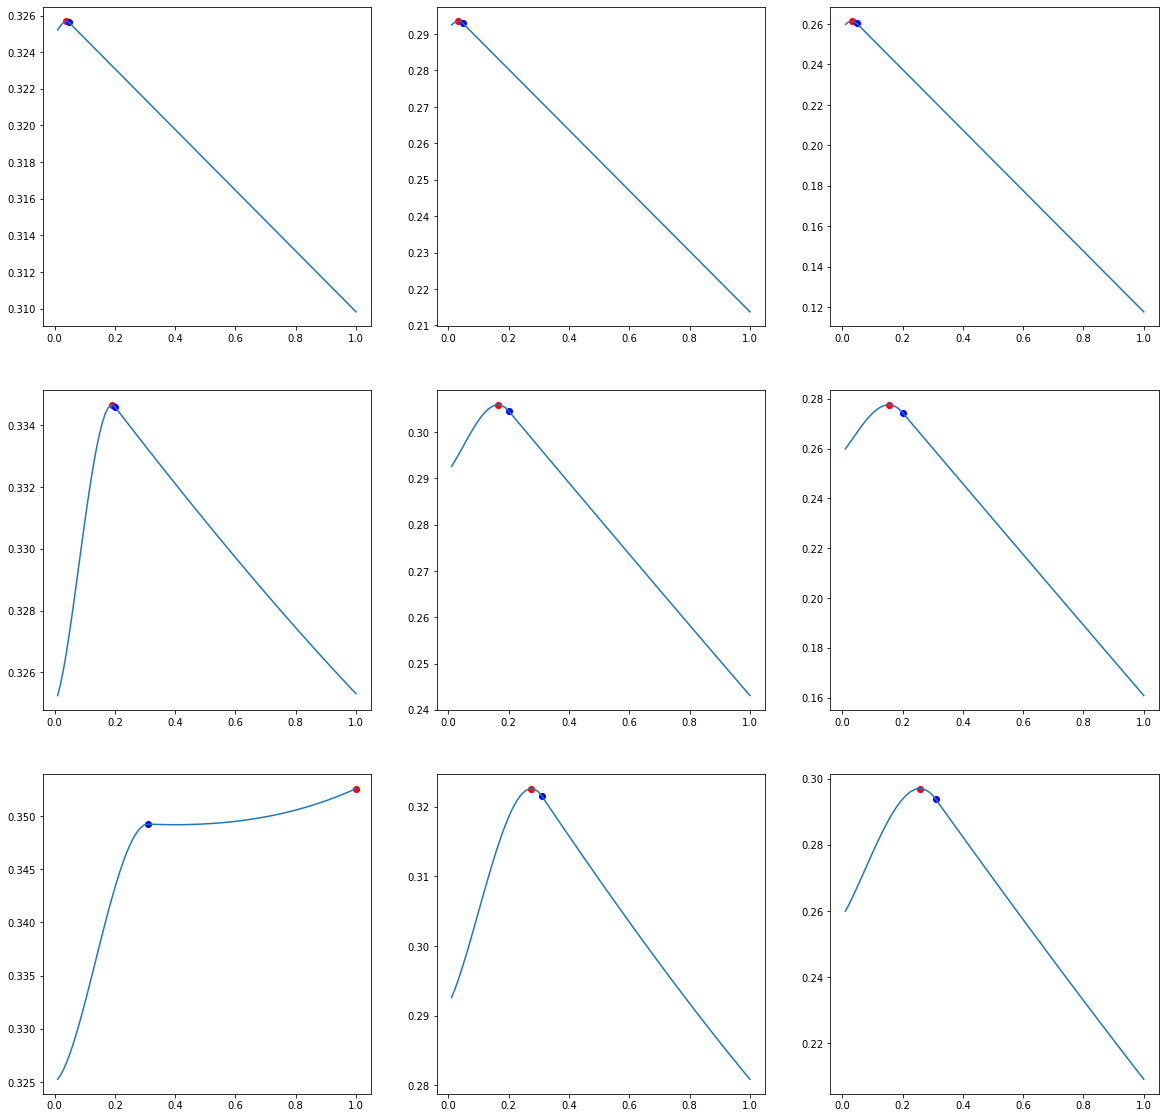

In [ ]:
a = 1
n = 2
list_s = np.linspace(0.01, 1, 101)
plt.figure(figsize=(20, 20))
for i in [1, 2, 3]:
    for j in [1, 2, 3]:
        list_u = []
        b = 0.2 * i - 0.15
        c = 0.2 * j - 0.15
        ha = honolulu(a, b, c, n)
        for val in list_s:
            list_u.append(ha.U(val))
        plt.subplot(3, 3, 3 * (i - 1) + j)
        plt.plot(list_s, list_u)
        plt.scatter(ha.s, ha.U(ha.s), color="red")
        plt.scatter(b / (1 + b), ha.U(b / (1 + b)), color="blue")



**Hypothesis** 
1. On the left of the cutoff point $s = \frac{b}{1+b}$, $EU_a(s)$ is increasing in $(0, s^{*})$ and decreasing in $(s^{*}, \frac{b}{1+b})$. Besides, $s^{*}$ becomes closer to the cutoff point for fixed $c$ and increasing $b$.
2. On the right of the cutoff point, fixing $c$, the decreasing rate of $EU_a$ in $s$ is decreasing in $b$, and can decrease to negetive (actually increasing then) for sufficiently small $c$ and large $b$. Besides, increasing $n$ will make the decreasing rate larger.

## <font color=dodgerblue>Why Dutch slightly outperforms Honolulu while it takes significantly longer time

### <font color=grey>Load program (run this first)

In [ ]:
def durationAndPaymentDist(a, b, c, n):
    ha = honolulu(a, b, c, n)
    da = dutch(a, b, c, n)
    v_array = np.linspace(1e-16, 1, 1000)
    # Honolulu dist
    ha_list = [[], [], []]
    for vi in v_array:
        p = ha.p(vi, ha.s)
        for xi in v_array:
            if xi <= vi:
                if xi <= p:
                    b_val = p
                    d_val = ha.s - p
                else:
                    b_val = xi
                    d_val = ha.s + xi - 2 * p
                db_prob = n * (n - 1) * xi ** (n - 2)
                ha_list[0].append(d_val)
                ha_list[1].append(b_val)
                ha_list[2].append(db_prob)
    # Dutch dist
    da_list = [[], [], []]
    for vi in v_array:
        d_val = 1 - da.beta(vi)
        b_val = da.beta(vi)
        db_prob = n * vi ** (n - 1)
        da_list[0].append(d_val)
        da_list[1].append(b_val)
        da_list[2].append(db_prob)

    num_bins = 50
    plt.figure(figsize=(15, 20))
    # Graph for jump-in price
    plt.subplot2grid((4, 3), (0, 1));
    plt.plot(v_array, v_array);
    plt.plot(v_array, list(map(lambda x: ha.p(x, ha.s), v_array)));
    plt.xlabel("Value");
    plt.ylabel("Bid");
    # Graph for duration distribution in HA and DA
    plt.subplot2grid((4, 2), (1, 0));
    plt.hist(ha_list[0], bins=num_bins, weights=ha_list[2], density=True, alpha=0.5);
    plt.hist(da_list[0], bins=num_bins, weights=da_list[2], density=True, alpha=0.5);
    plt.xlabel("Duration");
    plt.ylabel("Prob");
    # Graph for payment distribution in HA and DA
    plt.subplot2grid((4, 2), (1, 1));
    plt.hist(ha_list[1], bins=num_bins, weights=ha_list[2], density=True, alpha=0.5);
    plt.hist(da_list[1], bins=num_bins, weights=da_list[2], density=True, alpha=0.5);
    plt.xlabel("Payment");
    plt.ylabel("Prob");
    # Graph for joint distribution of duration and payment in HA
    hist, xedges, yedges = np.histogram2d(ha_list[0], ha_list[1], bins=num_bins, range=[[0, 1], [0, 1]], weights=ha_list[2], density=True)
    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0
    dx = dy = (1 / num_bins) * np.ones_like(zpos)
    dz = hist.ravel()
    ax = plt.subplot2grid((4, 2), (2, 0), rowspan=2, colspan=2, projection="3d");
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz);
    ax.set_xlabel("Duration");
    ax.set_ylabel("Payment");
    ax.set_zlabel("Prob");

### <font color=grey>$b=0.25,c=0.25,n=5$

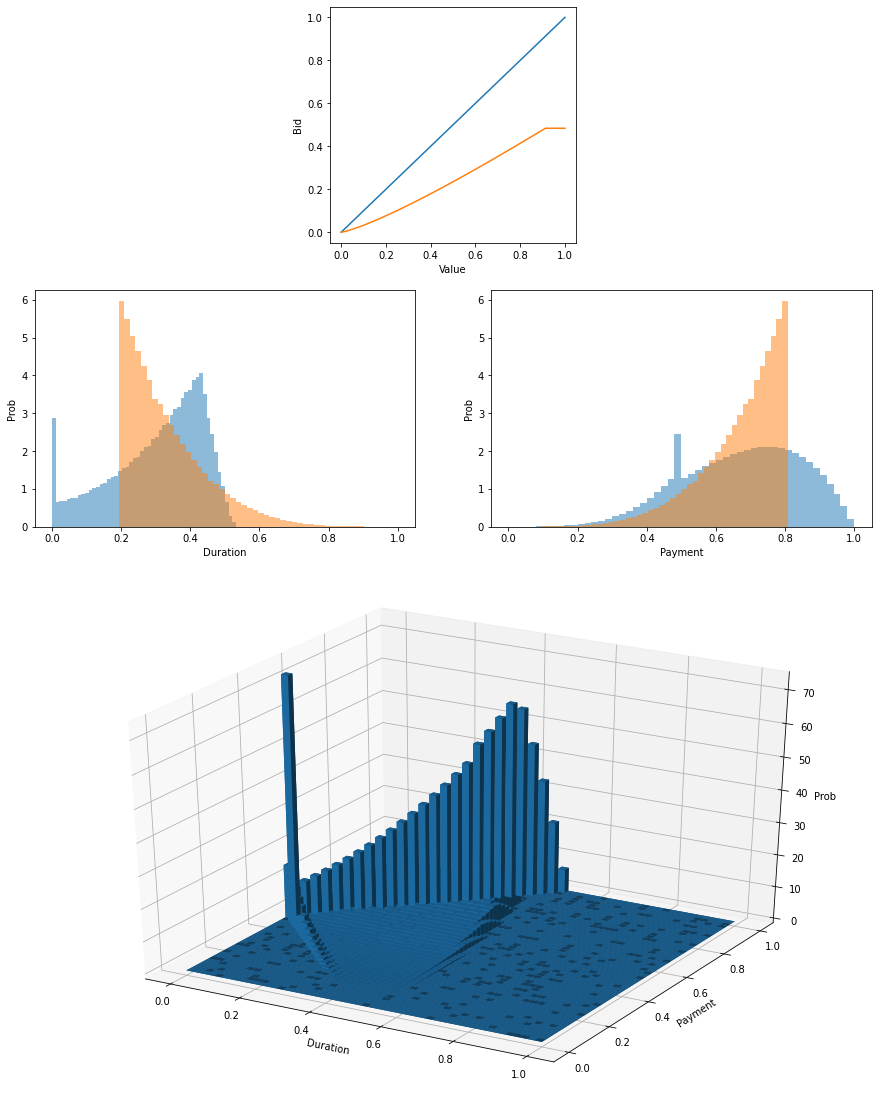

In [ ]:
durationAndPaymentDist(1, 0.25, 0.25, 5)

### <font color=grey>2*2 experiment: $c=0.25, b \in \{0.05, 0.45\}, n \in \{2, 5\}$

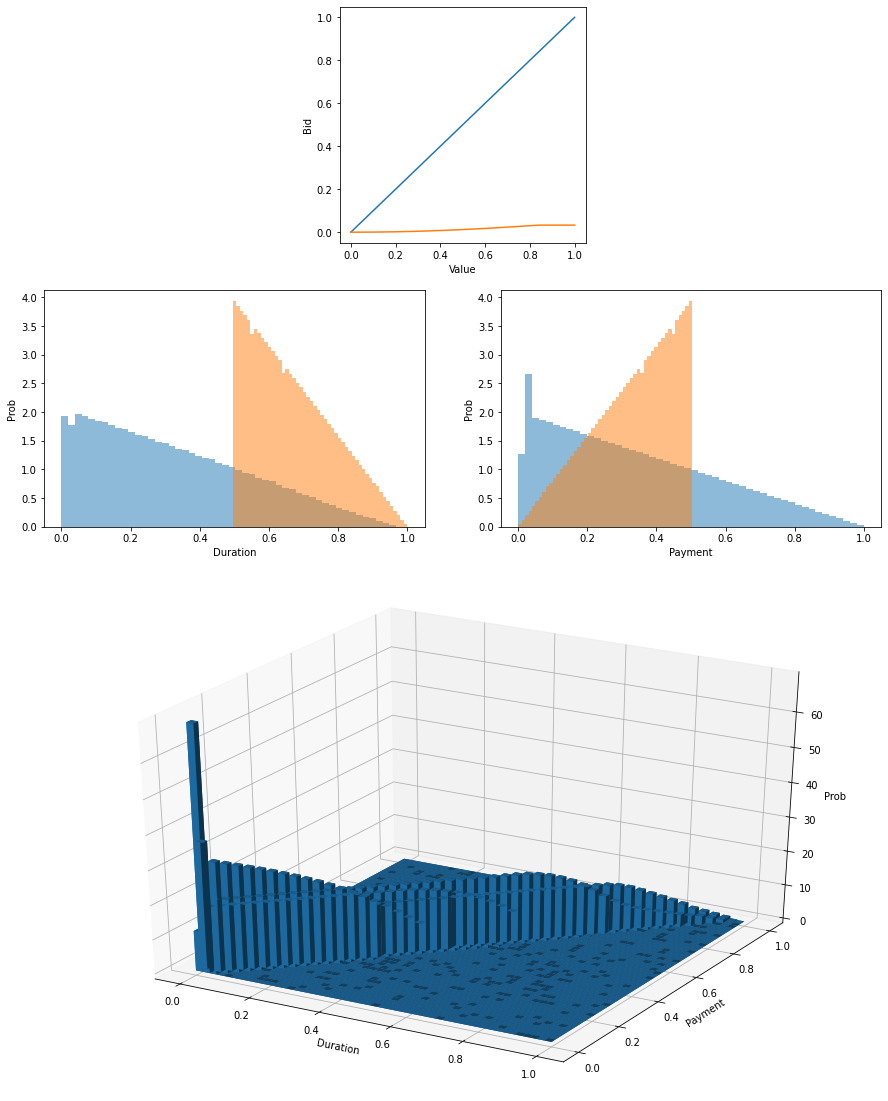

In [ ]:
durationAndPaymentDist(1, 0.05, 0.25, 2)

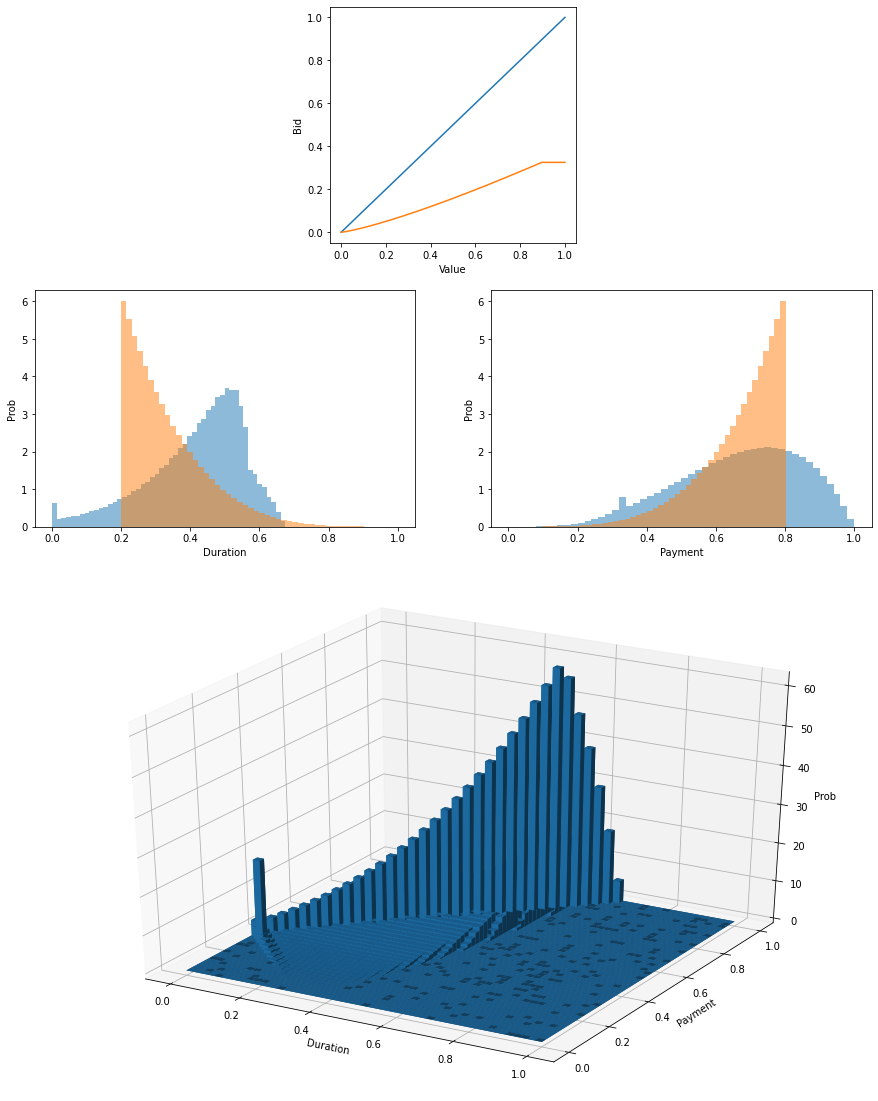

In [ ]:
durationAndPaymentDist(1, 0.05, 0.25, 5)

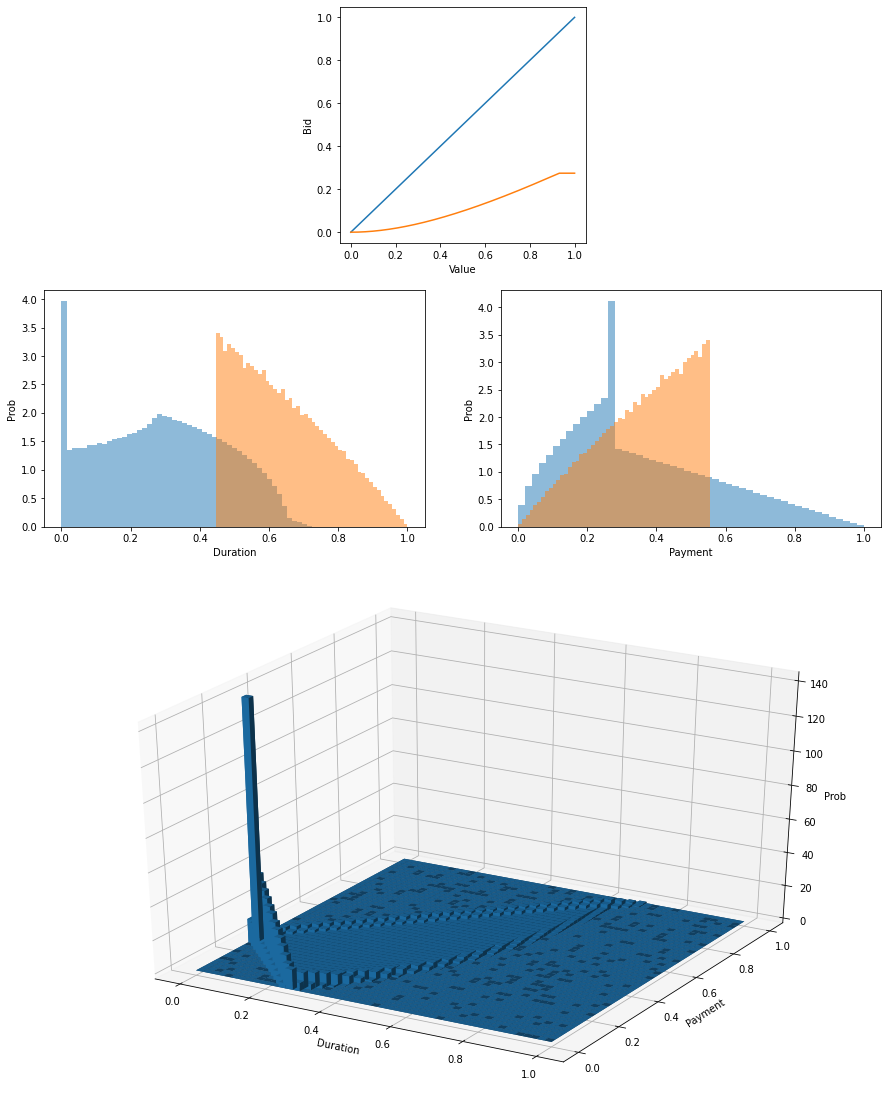

In [ ]:
durationAndPaymentDist(1, 0.45, 0.25, 2)

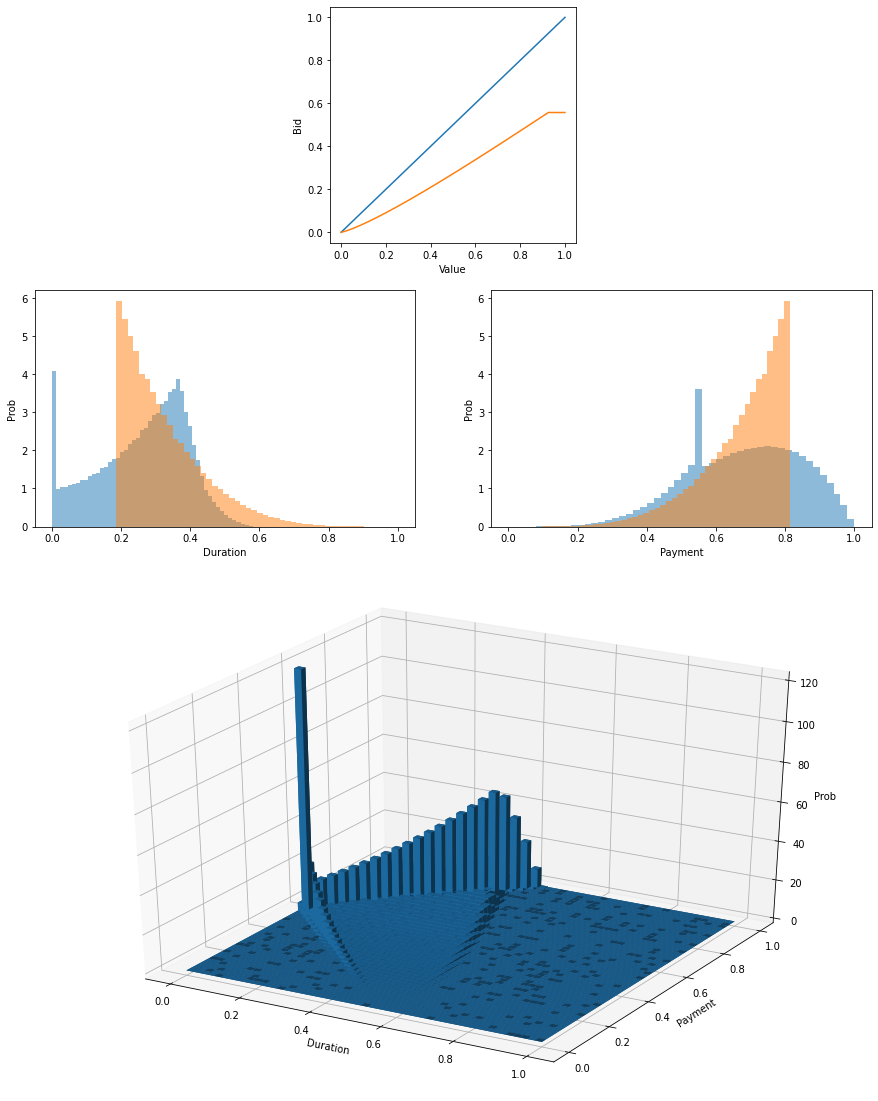

In [ ]:
durationAndPaymentDist(1, 0.45, 0.25, 5)

# <font color=blue>**Outputs for research use** (follow the instruction)

## <font color=dodgerblue>Change parameters here. **RUN** to confirm changes **each time** you change the parameters (even if you decide to use the default setting). **Here is the only place you can make changes**.

In [5]:
n = 5 # number of bidders
a = 1
b = 0.95 # discount for bidder （a - bt）
c = 0.95 # discount for auctioneer (a - ct)

# number of values in the sequence for b
# for example, num = 3 for [0, 0.25, 0.5]
num = 6

## <font color=dodgerblue>View results here. **RUN** each cell separately depending on your need (once the parameters has been confirmed, cells in this subsection can be run for arbitrarily many times).

### <font color=grey>Results table when specifying all parameters

In [6]:
def resultAllParameterSpecified(a, b, c, n):
    ha = honolulu(a, b, c, n)
    da = dutch(a, b, c, n)
    print("Confirmed parameters:")
    print("a = %d, b = %.2f, c = %.2f, n = %d" % (a, b, c, n))
    print("Results table:")
    print("\tHA\tDA")
    print("EUa\t%.4f\t%.4f" % (ha.EUa(), da.EUa()))
    print("ER\t%.4f\t%.4f" % (ha.ER(), da.ER()))
    print("ED\t%.4f\t%.4f" % (ha.ED(), da.ED()))
    print("EUb\t%.4f\t%.4f" % (ha.EUb(), da.EUb()))
    list_v = np.linspace(0.01, 1, 100)
    list_ha_eUb = []
    list_da_eUb = []
    list_ha_ePb = []
    list_da_ePb = []
    for iv in list_v:
        list_ha_eUb.append(ha.eUb(iv))
        list_da_eUb.append(da.eUb(iv))
        list_ha_ePb.append(ha.ePb(iv))
        list_da_ePb.append(da.ePb(iv))
    plt.figure("all_eUb")
    plt.plot(list_v, list_ha_eUb, label="Honolulu")
    plt.plot(list_v, list_da_eUb, label="Dutch")
    plt.title("$eU_b$")
    plt.xlabel("v")
    plt.rcParams["figure.figsize"] = (8, 6)
    plt.legend()
    plt.figure("all_ePb")
    plt.plot(list_v, list_ha_ePb, label="Honolulu")
    plt.plot(list_v, list_da_ePb, label="Dutch")
    plt.title("$eP_b$")
    plt.xlabel("v")
    plt.rcParams["figure.figsize"] = (8, 6)
    plt.legend() 

Confirmed parameters:
a = 1, b = 0.95, c = 0.95, n = 5
Results table:
	HA	DA
EUa	0.5581	0.5034
ER	0.6899	0.6926
ED	0.1991	0.3074
EUb	0.0253	0.0205


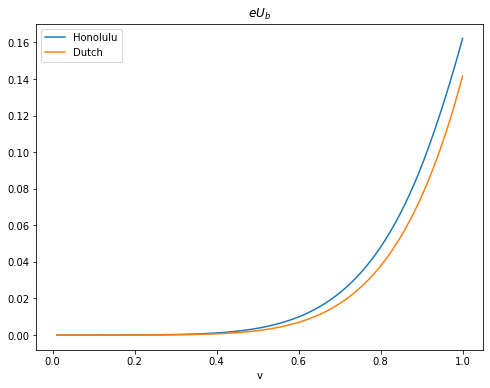

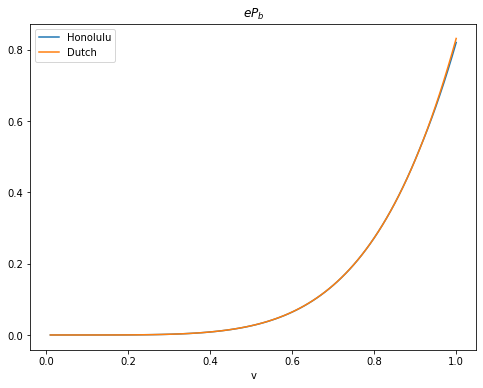

In [8]:
resultAllParameterSpecified(1, 0.95, 0.95, 5)

### <font color=grey> Plots for varying *b*



#### Run this first to generate plot data. (Run again only when you confirm changes to parameters, no need to run again if you only want to view different plots below)

In [ ]:
list_b = np.linspace(0, 0.5, num)
list_ha_EUa = []
list_da_EUa = []
list_ha_ER = []
list_da_ER = []
list_ha_ED = []
list_da_ED = []
for ib in list_b:
  ha = honolulu(a, ib, c, n)
  da = dutch(a, ib, c, n)
  list_ha_EUa.append(ha.EUa())
  list_da_EUa.append(da.EUa())
  list_ha_ER.append(ha.ER())
  list_da_ER.append(da.ER())
  list_ha_ED.append(ha.ED())
  list_da_ED.append(da.ED())
print("Confirmed parameters:")
print("a = %d, c = %.2f, n = %d" % (a, c, n))

Confirmed parameters:
a = 1, c = 0.00, n = 2


#### Plot for EUa

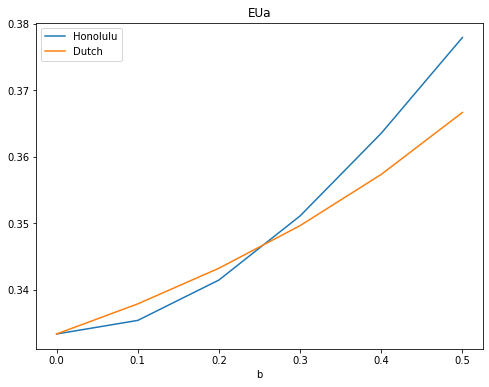

In [ ]:

plt.figure("varb_EUa")
plt.plot(list_b, list_ha_EUa, label="Honolulu");
plt.plot(list_b, list_da_EUa, label="Dutch");
plt.title("EUa");
plt.xlabel("b");
plt.rcParams["figure.figsize"] = (8, 6)
plt.legend();

#### Plot for ER

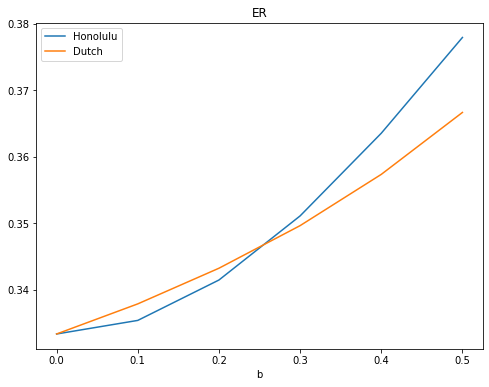

In [ ]:
plt.figure("varb_ER")
plt.plot(list_b, list_ha_ER, label="Honolulu");
plt.plot(list_b, list_da_ER, label="Dutch");
plt.title("ER");
plt.xlabel("b");
plt.rcParams["figure.figsize"] = (8, 6)
plt.legend();

#### Plot for ED

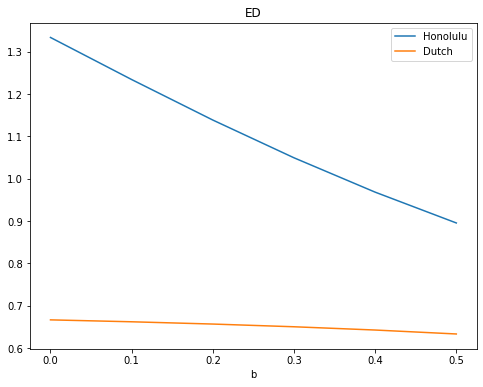

In [ ]:
plt.figure("varb_ED")
plt.plot(list_b, list_ha_ED, label="Honolulu");
plt.plot(list_b, list_da_ED, label="Dutch");
plt.title("ED");
plt.xlabel("b");
plt.rcParams["figure.figsize"] = (8, 6)
plt.legend();

## <font color=dodgerblue>Tables of concerned variables for parameters used in the experiment

### <font color=grey>Load program (run this first)

In [4]:
def table(a, b, c, list_n):
    varlist = [
        "Expected Utility for Auctioneer",
        "Expected Revenue",
        "Expected Duration",
        "Expected Utility for Bidder",
    ]      
    list_ha = []
    list_da = []
    list_s = []
    print("b = %.2f, c = %.2f" % (b, c))
    for n in list_n:
        print("\t%d" % n, end="")
        ha = honolulu(a, b, c, n)
        da = dutch(a, b, c, n)
        list_ha.append([
            ha.EUa(),
            ha.ER(),
            ha.ED(),
            ha.EUb(),
        ])
        list_s.append(ha.s)
        list_da.append([
            da.EUa(),
            da.ER(),
            da.ED(),
            da.EUb(),
        ])
    for i in range(len(varlist)):
        print("\n", end="")
        print(varlist[i])
        print("HA", end="")
        for j in range(len(list_n)):
            print("\t%.4f" % list_ha[j][i], end="")
        print("\n", end="")
        print("DA", end="")
        for j in range(len(list_n)):
            print("\t%.4f" % list_da[j][i], end="")
    print("\n", end="")
    print("Optimal Starting Price")
    print("HA", end="")
    for i in range(len(list_n)):
        print("\t%.4f" % list_s[i], end="")
    print("\n", end="")

### <font color=grey> $b \in \{0.05,0.25,0.45\},c=0.05$

In [7]:
for b in [0.45, 0.95]:
    table(1, b, 0.95, [2, 5])

b = 0.45, c = 0.95
	2	5
Expected Utility for Auctioneer
HA	0.2342	0.5039
DA	0.1593	0.4816
Expected Revenue
HA	0.3526	0.6773
DA	0.3618	0.6768
Expected Duration
HA	0.2729	0.2582
DA	0.6382	0.3232
Expected Utility for Bidder
HA	0.1452	0.0289
DA	0.1117	0.0270
Optimal Starting Price
HA	0.2370	0.5405
b = 0.95, c = 0.95
	2	5
Expected Utility for Auctioneer
HA	0.2964	0.5581
DA	0.2245	0.5034
Expected Revenue
HA	0.3922	0.6899
DA	0.4346	0.6926
Expected Duration
HA	0.2456	0.1991
DA	0.5654	0.3074
Expected Utility for Bidder
HA	0.1176	0.0253
DA	0.0596	0.0205
Optimal Starting Price
HA	0.4104	0.6317


In [ ]:
for b in [0.05, 0.25, 0.45]:
    table(1, b, 0.05, [2, 3, 4, 5, 6])

b = 0.05, c = 0.05
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.3257	0.4884	0.5866	0.6526	0.7001
DA	0.3251	0.4901	0.5900	0.6572	0.7054
Expected Revenue
HA	0.3338	0.5009	0.6010	0.6675	0.7150
DA	0.3355	0.5017	0.6013	0.6676	0.7150
Expected Duration
HA	0.3262	0.4214	0.4322	0.4187	0.3985
DA	0.6645	0.4983	0.3987	0.3324	0.2850
Expected Utility for Bidder
HA	0.1645	0.0818	0.0490	0.0326	0.0233
DA	0.1625	0.0805	0.0481	0.0320	0.0228
Optimal Starting Price
HA	0.0388	0.1517	0.2524	0.3329	0.3973
b = 0.25, c = 0.05
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.3347	0.4994	0.5969	0.6619	0.7084
DA	0.3357	0.4980	0.5958	0.6615	0.7087
Expected Revenue
HA	0.3420	0.5096	0.6080	0.6730	0.7194
DA	0.3463	0.5096	0.6070	0.6719	0.7183
Expected Duration
HA	0.3217	0.3563	0.3408	0.3182	0.2965
DA	0.6537	0.4904	0.3930	0.3281	0.2817
Expected Utility for Bidder
HA	0.1536	0.0754	0.0453	0.0303	0.0218
DA	0.1446	0.0692	0.0406	0.0267	0.0189
Optimal Starting Price
HA	0.1902	0.3492	0.4452	0.5114	0.5607
b = 0.45, c = 0.05
	

### <font color=grey> $b \in \{0.05, 0.25, 0.45\},c=0.25$

In [ ]:
for b in [0.05, 0.25, 0.45]:
    table(1, b, 0.25, [2, 3, 4, 5, 6])

b = 0.05, c = 0.25
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.2935	0.4384	0.5294	0.5930	0.6404
DA	0.2833	0.4434	0.5451	0.6154	0.6668
Expected Revenue
HA	0.3337	0.5009	0.6009	0.6675	0.7150
DA	0.3355	0.5017	0.6013	0.6676	0.7150
Expected Duration
HA	0.3232	0.4178	0.4297	0.4170	0.3973
DA	0.6645	0.4983	0.3987	0.3324	0.2850
Expected Utility for Bidder
HA	0.1645	0.0818	0.0490	0.0327	0.0233
DA	0.1625	0.0805	0.0481	0.0320	0.0228
Optimal Starting Price
HA	0.0329	0.1416	0.2430	0.3250	0.3909
b = 0.25, c = 0.25
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.3059	0.4598	0.5538	0.6181	0.6652
DA	0.2936	0.4516	0.5512	0.6200	0.6704
Expected Revenue
HA	0.3414	0.5087	0.6072	0.6725	0.7190
DA	0.3463	0.5096	0.6070	0.6719	0.7183
Expected Duration
HA	0.3024	0.3364	0.3254	0.3068	0.2880
DA	0.6537	0.4904	0.3930	0.3281	0.2817
Expected Utility for Bidder
HA	0.1546	0.0760	0.0456	0.0305	0.0219
DA	0.1446	0.0692	0.0406	0.0267	0.0189
Optimal Starting Price
HA	0.1641	0.3151	0.4135	0.4838	0.5371
b = 0.45, c = 0.25
	

### <font color=grey> $b \in \{0.05, 0.25, 0.45\},c=0.35$

In [ ]:
for b in [0.05, 0.25, 0.45]:
    table(1, b, 0.35, [2, 3, 4, 5, 6])

b = 0.05, c = 0.35
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.2775	0.4135	0.5007	0.5632	0.6106
DA	0.2624	0.4201	0.5227	0.5944	0.6475
Expected Revenue
HA	0.3337	0.5008	0.6009	0.6675	0.7150
DA	0.3355	0.5017	0.6013	0.6676	0.7150
Expected Duration
HA	0.3229	0.4176	0.4296	0.4169	0.3972
DA	0.6645	0.4983	0.3987	0.3324	0.2850
Expected Utility for Bidder
HA	0.1645	0.0818	0.0490	0.0327	0.0233
DA	0.1625	0.0805	0.0481	0.0320	0.0228
Optimal Starting Price
HA	0.0322	0.1406	0.2422	0.3244	0.3904
b = 0.25, c = 0.35
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.2917	0.4402	0.5324	0.5964	0.6437
DA	0.2725	0.4284	0.5289	0.5993	0.6513
Expected Revenue
HA	0.3411	0.5085	0.6071	0.6724	0.7189
DA	0.3463	0.5096	0.6070	0.6719	0.7183
Expected Duration
HA	0.2988	0.3340	0.3240	0.3060	0.2874
DA	0.6537	0.4904	0.3930	0.3281	0.2817
Expected Utility for Bidder
HA	0.1549	0.0761	0.0457	0.0305	0.0219
DA	0.1446	0.0692	0.0406	0.0267	0.0189
Optimal Starting Price
HA	0.1579	0.3092	0.4089	0.4803	0.5344
b = 0.45, c = 0.35
	

### <font color=grey> $b \in \{0.05, 0.25, 0.45\},c=0.45$

In [ ]:
for b in [0.05, 0.25, 0.45]:
    table(1, b, 0.45, [2, 3, 4, 5, 6])

b = 0.05, c = 0.45
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.2614	0.3885	0.4721	0.5334	0.5807
DA	0.2416	0.3968	0.5002	0.5735	0.6282
Expected Revenue
HA	0.3337	0.5008	0.6009	0.6675	0.7150
DA	0.3355	0.5017	0.6013	0.6676	0.7150
Expected Duration
HA	0.3228	0.4174	0.4295	0.4169	0.3972
DA	0.6645	0.4983	0.3987	0.3324	0.2850
Expected Utility for Bidder
HA	0.1646	0.0818	0.0490	0.0327	0.0233
DA	0.1625	0.0805	0.0481	0.0320	0.0228
Optimal Starting Price
HA	0.0319	0.1401	0.2418	0.3240	0.3901
b = 0.25, c = 0.45
	2	3	4	5	6
Expected Utility for Auctioneer
HA	0.2776	0.4207	0.5111	0.5746	0.6222
DA	0.2514	0.4052	0.5066	0.5785	0.6321
Expected Revenue
HA	0.3410	0.5084	0.6070	0.6723	0.7189
DA	0.3463	0.5096	0.6070	0.6719	0.7183
Expected Duration
HA	0.2965	0.3327	0.3233	0.3055	0.2872
DA	0.6537	0.4904	0.3930	0.3281	0.2817
Expected Utility for Bidder
HA	0.1550	0.0762	0.0457	0.0306	0.0219
DA	0.1446	0.0692	0.0406	0.0267	0.0189
Optimal Starting Price
HA	0.1537	0.3055	0.4061	0.4782	0.5328
b = 0.45, c = 0.45
	